In [2]:
import cv2
import numpy as np
import pandas as pd
import os
from color_embeddings import get_vector
from sklearn.metrics.pairwise import cosine_similarity
from autoencoder_resnet18 import Img2VecResnet18
from PIL import Image
import matplotlib.pyplot as plt
import sqlite3

In [3]:
# Database with the image metadata
database_path = '/Volumes/T7 Shield/Uni/4. Semester/Big Data Engineering/image_database.db'
table_name = 'image_database'

# load color embeddings
color_embeddings = pd.read_pickle("color_vectors.pkl")

# load image embeddings
image_embeddings = pd.read_pickle("image_vectors.pkl")

In [4]:
# function to display an image
def show_image(image_path, title):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [5]:
def get_image_path(database_path, table_name, image_id):
    """Get image path based on image id"""
    with sqlite3.connect(database_path) as conn:
        curs = conn.cursor()
        curs.execute(f"SELECT filepath, filename FROM {table_name} WHERE imageid = ?", (image_id,))
        result = curs.fetchone()  # Fetch the first matching row
        filepath, filename = result
        return os.path.join(filepath, filename)  # Combine the path and filename

In [6]:
def get_similar_images(image_path, mode, number_pictures):
    img2vec = Img2VecResnet18()    
    
    if mode == "color":
        image_ids, vectors = zip(*color_embeddings.items())
        embeddings = np.array(vectors)

        # calculate color embedding for the input image
        query_vector = get_vector(image_path)

    elif mode == "content":
        image_ids, vectors = zip(*image_embeddings.items())
        embeddings = np.array(vectors)

        I = Image.open(image_path)
        # calculate embedding for input image
        query_vector = img2vec.getVec(I)
    
    # calculate similarity scores
    scores = cosine_similarity([query_vector], embeddings)[0]
    # Find the closest 10 vectors and their similarity scores
    closest_indices = np.argsort(-scores)[:number_pictures]
    closest_vectors = scores[closest_indices]

    # find image IDs of the 10 most similar images
    closest_image_ids = [image_ids[i] for i in closest_indices]

    # display input image
    show_image(image_path, "Input Image")

    # find and display selected number of most similar images
    for i in range(number_pictures):
        closest_image_id = closest_image_ids[i]
        closest_score = closest_vectors[i]
        
        # get image path and set title
        image_path = get_image_path(database_path, table_name, closest_image_id)
        title = f"ID: {closest_image_id}, Score: {closest_score:.2f}"

        # display most similar image
        show_image(image_path, title)

/Users/nick/opt/anaconda3/envs/big_data/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nick/opt/anaconda3/envs/big_data/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
[W NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


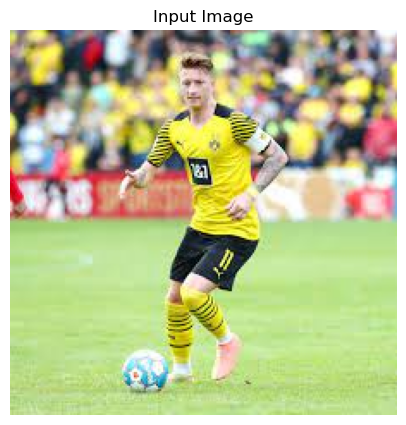

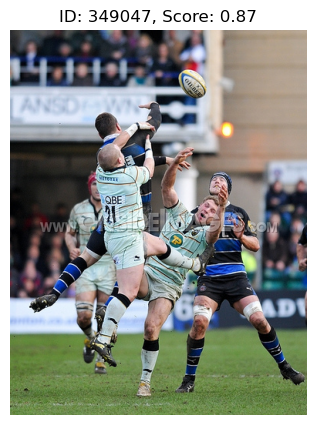

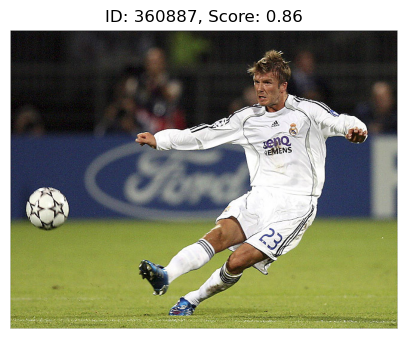

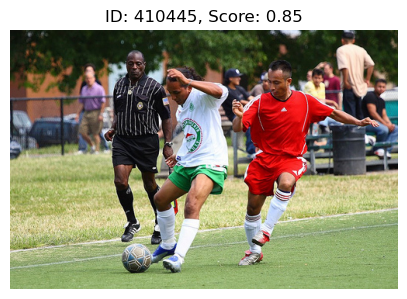

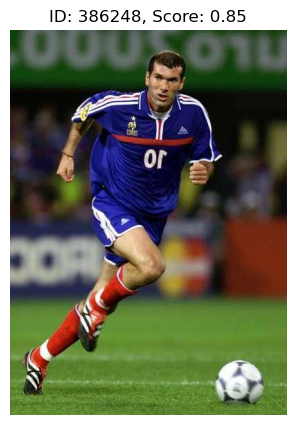

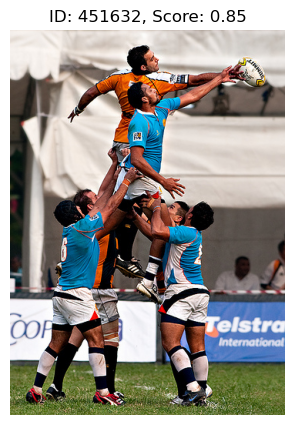

In [7]:
image_path = '/Users/nick/Downloads/reus_ball.jpeg'
get_similar_images(image_path, "content", 5)